In [ ]:
%load_ext autoreload

In [41]:
%autoreload 2

In [39]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def f(a):
    # create 1000 equally spaced points between -10 and 10
    x = np.linspace(-10, 10, 1000)
    y = x**2 + a*x + 2  
    plt.plot(x, y)
    plt.tight_layout()
    return a

In [6]:
interact(f, a=10);

interactive(children=(IntSlider(value=10, description='a', max=30, min=-10), Output()), _dom_classes=('widget-…

	samples 888 lines 777 bands 3
+r ../data/ubc/G80223_20230513.bin


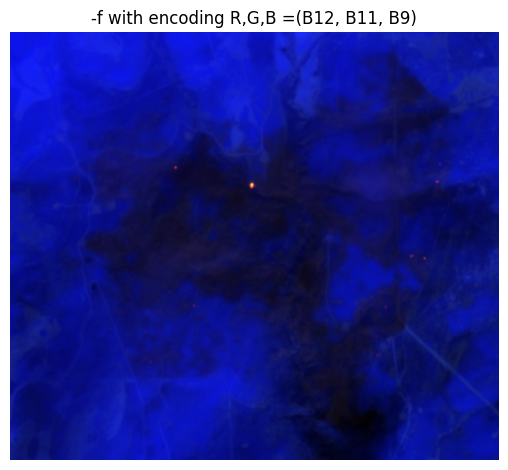

In [1]:
from misc import read_binary
from view import plot
samples, lines, bands, data =read_binary("../data/ubc/G80223_20230513.bin")
plot("../data/ubc/G80223_20230513.bin", False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


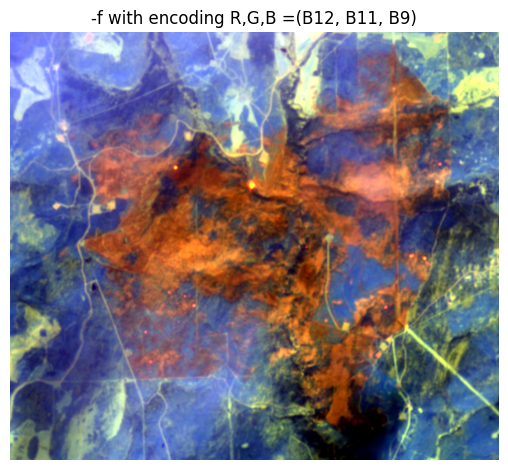

In [8]:
plot("../data/ubc/G80223_20230513.bin", True)

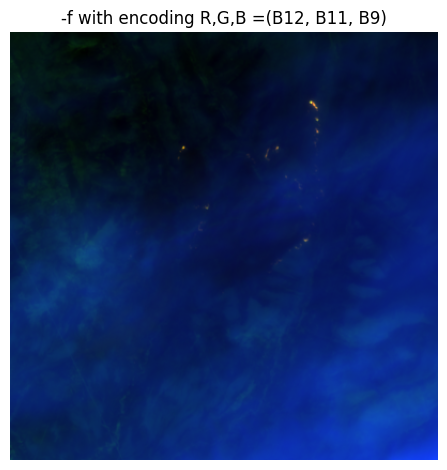

In [9]:
plot("../data/ubc/G90292_20230514.bin", False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


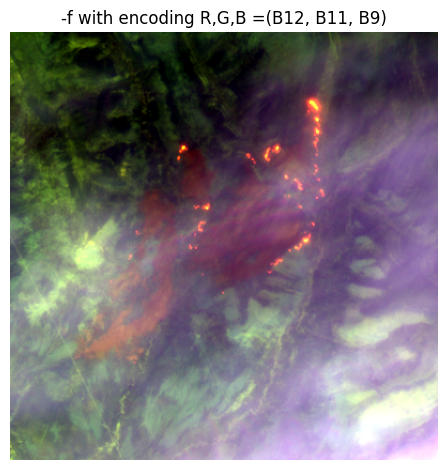

In [10]:
plot("../data/ubc/G90292_20230514.bin", True)


In [42]:
MIN_FIRE_SIZE_HA = .1
TOP_N = 10

import datetime
import zipfile
import shutil
import urllib
import json
from osgeo import ogr
t = datetime.datetime.now().strftime("%Y%m%d%H%M")  # timestamped backup

# save "fire polygon" shapefile
fn = 'prot_current_fire_polys.zip'
dl_path = 'https://pub.data.gov.bc.ca/datasets/cdfc2d7b-c046-4bf0-90ac-4897232619e1/' + fn
urllib.request.urlretrieve(dl_path, fn)
ofn = 'prot_current_fire_polys_' + t + '.zip'
shutil.copyfile(fn, ofn)
zipfile.ZipFile(fn).extractall()
print(ofn)

# save "fire point" shapefile
fn = 'prot_current_fire_points.zip'
dl_path = 'https://pub.data.gov.bc.ca/datasets/2790e3f7-6395-4230-8545-04efb5a18800/' + fn
urllib.request.urlretrieve(dl_path, fn)
ofn = 'prot_current_fire_points_' + t + '.zip'
shutil.copyfile(fn, ofn)
zipfile.ZipFile(fn).extractall()
print(ofn)

selected = []

# Open Shapefile
Shapefile = ogr.Open('prot_current_fire_points.shp') # print(Shapefile)
layer = Shapefile.GetLayer()
layerDefinition = layer.GetLayerDefn()
feature_count = layer.GetFeatureCount()
spatialRef = layer.GetSpatialRef()

def records(layer):
    for i in range(layer.GetFeatureCount()):
        feature = layer.GetFeature(i)
        yield json.loads(feature.ExportToJson())

features = records(layer)
feature_names, feature_ids = [], []
for f in features:
    for key in f.keys():
        if key == 'properties':
            fk = f[key]
            # print(fk)
            fire_size = float(fk['CURRENT_SZ'])

            if False:  # not out and larger than MIN_FIRE_SIZE_HA
                if fk['STATUS'].lower() != 'out' and fire_size >= MIN_FIRE_SIZE_HA:  # > biggest_size
                    selected.append([fk['CURRENT_SZ'], fk])  # selected fires
                    #print(fk)
            if False:
                if fk['STATUS'].lower() == 'out':
                    selected.append([fk['CURRENT_SZ'], fk])
            if False:  # fire of note
                if fk['STATUS'] ==  'Fire of Note':
                    selected.append([fk['CURRENT_SZ'], fk])

            if True:  # out of control
                if fk['STATUS'] == 'Out of Control':
                    selected.append([fk['CURRENT_SZ'], fk])

            if False:  # being held
                if fk['STATUS'] == 'Being Held':
                    selected.append([fk['CURRENT_SZ'], fk])

selected = list(selected)

# remove duplicates
selected = [json.loads(s) for s in list(set([json.dumps(s) for s in selected]))]

# sort by order of size, largest first
ix = [[selected[i][0], i] for i in range(len(selected))]
ix.sort(reverse=True)
#ix.sort(reverse=False)
#print("ix", ix)
selected = [selected[i[1]] for i in ix]

# select the top TOP_N by size
selected = selected[0: TOP_N]
for s in selected:
    print(s)


prot_current_fire_polys_202405201705.zip
prot_current_fire_points_202405201705.zip
[83567.0, {'FIRE_NUM': 'G90228', 'FIRE_YEAR': 2024, 'RSPNCE_TYP': 'Full', 'IGNITN_DT': '2024/05/05', 'FIREOUT_DT': None, 'STATUS': 'Out of Control', 'FIRE_CAUSE': 'Lightning', 'FIRE_CENTR': 4, 'ZONE': 9, 'FIRE_ID': 228, 'FIRE_TYPE': 'Fire', 'INCIDNT_NM': '2024 Holdover Nogah Creek', 'GEOGRAPHIC': 'Nogah Creek', 'LATITUDE': 58.794, 'LONGITUDE': -121.6269, 'CURRENT_SZ': 83567.0, 'FIRE_LINK': 'https://wildfiresituation.nrs.gov.bc.ca/incidents?fireYear=2024&incidentNumber=G90228', 'FIRE_NT': 'N', 'WS_FIRE_NT': 'N', 'FEATURE_CD': 0.0, 'OBJECTID': 639980}]
[35012.0, {'FIRE_NUM': 'G90289', 'FIRE_YEAR': 2024, 'RSPNCE_TYP': 'Full', 'IGNITN_DT': '2024/05/11', 'FIREOUT_DT': None, 'STATUS': 'Out of Control', 'FIRE_CAUSE': 'Lightning', 'FIRE_CENTR': 4, 'ZONE': 9, 'FIRE_ID': 289, 'FIRE_TYPE': 'Fire', 'INCIDNT_NM': '2024 Holdover G93291', 'GEOGRAPHIC': 'Gote Creek / Tsea River', 'LATITUDE': 59.6011, 'LONGITUDE': -121.8

In [38]:
# Look at the smoke locations from GeoBC flight?

<Axes: >

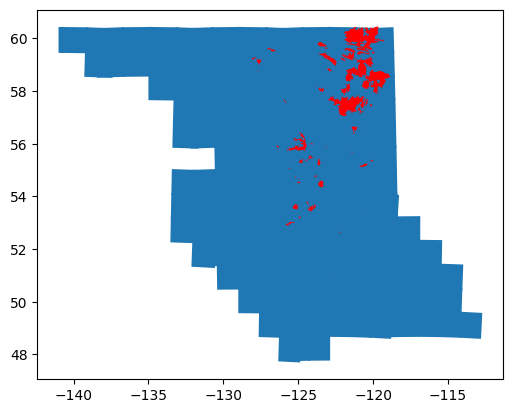

In [53]:
import geopandas as gpd
s2_df = gpd.read_file('sentinel2_bc_tiles_shp/Sentinel_BC_Tiles.shp')
fire_df = gpd.read_file('prot_current_fire_polys.shp')

s2_df = s2_df.to_crs(4326)
fire_df = fire_df.to_crs(4326)


ax1 = s2_df.plot()
fire_df.plot(ax=ax1, color="red")
